In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
 
import torch 
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
 
manualSeed = 31

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
 
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

Random Seed:  31
cuda:0


Since it is a basic GAN, we don't need any class labels, hence I just get into the data folder, and set img_align_celeba as the class name to trick torch. According to Ian Goodfellow et al, in UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS https://arxiv.org/pdf/1511.06434.pdf, No pre-processing was applied to training images besides scaling to the range of the tanh activation
function [-1, 1]. All models were trained with mini-batch stochastic gradient descent (SGD) with
a mini-batch size of 128. All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02


In [20]:
transform = transforms.Compose([transforms.Resize((64)),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='data', transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


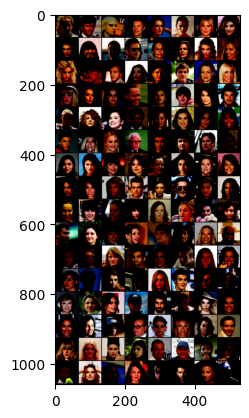

In [21]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(data_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

In [22]:
"""
     Weight Initialization as Goodfellow sugested
"""
def init_normal(m):
    classname = m.__class__.__name__
 
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
feature_map = 64
latent_space_size = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.convTranspose1 = nn.ConvTranspose2d(latent_space_size, feature_map*8, 4, 1, 0, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(feature_map*8)
        self.convTranspose2 = nn.ConvTranspose2d(feature_map*8, feature_map*4, 4, 2, 1, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(feature_map*4)
        self.convTranspose3 = nn.ConvTranspose2d(feature_map*4, feature_map*2, 4, 2, 1, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(feature_map*2)
        self.convTranspose4 = nn.ConvTranspose2d(feature_map*2, feature_map, 4, 2, 1, bias=False)
        self.batchNorm4 = nn.BatchNorm2d(feature_map)
        self.convTranspose5 = nn.ConvTranspose2d(feature_map, 3, 4, 2, 1, bias=False)

        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.LeakyReLU(self.batchNorm1(self.convTranspose1(x)))
        x = self.LeakyReLU(self.batchNorm2(self.convTranspose2(x)))
        x = self.LeakyReLU(self.batchNorm3(self.convTranspose3(x)))
        x = self.LeakyReLU(self.batchNorm4(self.convTranspose4(x)))
        x = self.sigmoid(self.convTranspose5(x))
        return x

generator = Generator().to(device)
        

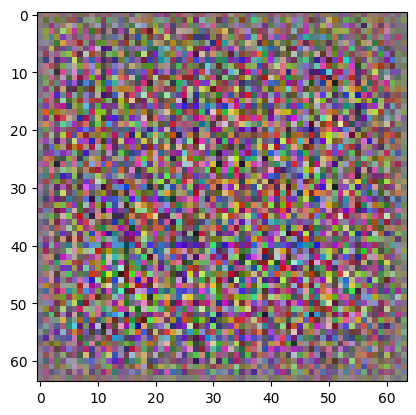

In [30]:
# The random noise in the latent space
def generate_latent_vectors_z(N):
    z = torch.randn(N, 100, 1, 1, device=device)
    return z   

z = generate_latent_vectors_z(1).to(device)
random_noise = generator(z)
 
plt.imshow(random_noise[0].cpu().permute(1, 2, 0).detach().numpy())

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, feature_map, 4, 2, 1, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(feature_map)
        self.conv2 = nn.Conv2d(feature_map, feature_map*2, 4, 2, 1, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(feature_map*2)
        self.conv3 = nn.Conv2d(feature_map*2, feature_map*4, 4, 2, 1, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(feature_map*4)
        self.conv4 = nn.Conv2d(feature_map*4, feature_map*8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(feature_map*8, 1, 4, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.batchNorm2(self.conv2(x)))
        x = self.LeakyReLU(self.batchNorm3(self.conv3(x)))
        x = self.LeakyReLU(self.conv4(x))
        x = self.sigmoid(self.conv5(x))
        return x

In [33]:
criterion = nn.BCELoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(init_normal)
discriminator.apply(init_normal)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
print("Starting training loop")
epochs = 100
print("Total epoch is: ", epochs)
n_samples = 128

for epoch in range(epochs):
    for idx, labels in enumerate(data_loader):
        discriminator.zero_grad()
        if(idx%100 == 0):
            print("Epoch: ", epoch, "Batch: ", idx)
        # Get samples from real data
        real_images = labels[0].to(device)
        real_labels = torch.ones(n_samples, device=device)
        # Train the discriminator on real data by forward passing real data to discriminator
        output = discriminator(real_images).view(-1)
        loss_real = criterion(output, real_labels)
        loss_real.backward()
        mean = output.mean().item()

        # Generate fake data
        z = generate_latent_vectors_z(n_samples).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(n_samples, device=device)

        output = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        loss_fake.backward()

        total_loss = loss_real + loss_fake
        discriminator_optimizer.step()

        # Train the generator
        generator.zero_grad()
        real_labels = torch.ones(fake_images.shape[0]).to(device) # The fake images are real for generator
        output = discriminator(fake_images).view(-1)
        loss_generator = criterion(output, real_labels)
        loss_generator.backward()
        generator_optimizer.step()
        
torch.save(generator.state_dict(), '/content/DCGAN_celeba_g.pth')
torch.save(discriminator.state_dict(), '/content/DCGAN_celeba_d.pth')

In [ ]:
z = generate_latent_vectors_z(100).to(device)
fake_data = generator(z)
plt.imshow(fake_data[10].cpu().permute(1, 2, 0).detach().numpy())